In [1]:
# Notebook 출력설정
# 주요 라이브러리 임포트

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 2000)
pd.set_option('display.max_columns',2000)
pd.set_option('display.width', 2000)

%matplotlib inline
import matplotlib.pylab as plt
plt.rcParams["figure.figsize"] = (15,5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['axes.grid'] = True
import seaborn as sns

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, KFold, RepeatedStratifiedKFold,StratifiedKFold,cross_val_predict
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings('ignore')
sns.set()

In [3]:
# 원본 데이터셋 로드
DIR_DATASET = "C:/Users/0stix/Datasets/"
NAME_PROJECT = "2203-kaggle-netflix_appetency"

In [4]:
train = pd.read_csv(DIR_DATASET + NAME_PROJECT + '/train.csv')
test = pd.read_csv(DIR_DATASET + NAME_PROJECT + '/test.csv')
sample = pd.read_csv(DIR_DATASET + NAME_PROJECT + '/sample_submission.csv')

In [5]:
def get_missings(df):
    labels,values = list(),list()
    if df.isna().sum().sum()>0:
        for column in df.columns:
            if df[column].isnull().sum():
                labels.append(column)
                values.append((df[column].isnull().sum() / len(df[column]))*100)
        missings=pd.DataFrame({'Feature':labels,'MissingPercent':values }).sort_values(by='MissingPercent',ascending=False)
        return missings
    else:
        return False

In [6]:
#Missing values report
Missings_df=get_missings(train)
Missings_df.head(10)

,Feature,MissingPercent
52,feature_193,100.000000
55,feature_196,100.000000
56,feature_197,100.000000
57,feature_198,100.000000
21,feature_83,98.320000
18,feature_75,70.297143
19,feature_76,70.297143
54,feature_195,63.890000
0,feature_5,63.680000
3,feature_8,63.680000


Text(0, 0.5, 'The number of features')

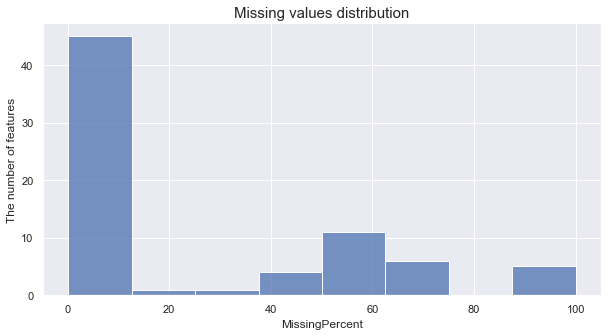

In [49]:
plt.figure(figsize=(10,5))
sns.histplot(x=Missings_df.MissingPercent).set_title('Missing values distribution',size=15)
plt.ylabel('The number of features')

In [7]:
#Get columns with more than 30% missing values
Missings_custom=Missings_df[Missings_df.MissingPercent>25]
#Drop from train and test 
train=train.drop(list(Missings_custom.Feature),axis=1)
test=test.drop(list(Missings_custom.Feature),axis=1)

In [8]:
#Categorical features name
Categorical_Features=train.select_dtypes(include=['object']).columns
        
#Numeric features name
Numeric_Features=train.select_dtypes(exclude=['object']).columns[2:] #skip id,target

In [9]:
#Fill with median
for col in Numeric_Features:
    train[col].fillna(train[col].median(),inplace=True)
    test[col].fillna(test[col].median(),inplace=True)

In [10]:
#Fill with mode
def get_mode(feature,df):
    return df[feature].mode()[0]

for col in Categorical_Features:
    train[col].fillna(get_mode(col,train),inplace=True)
    test[col].fillna(get_mode(col,test),inplace=True)

In [11]:
#Find columns that contain date objects
mask = train[Categorical_Features][:10].astype(str).apply(lambda x : x.str.match('(\d{2,4}(-|\/|\\|\.| )\d{2}(-|\/|\\|\.| )\d{2,4})+').any())
datetime_Features=train[Categorical_Features].loc[:,mask]

datetime_Features

,feature_191,feature_192,feature_199,feature_200,feature_201
0,11/10/2017,11/10/2017,11/10/2017,17/01/2016,11/10/2017
1,25/03/2015,25/03/2015,02/04/2017,25/03/2015,25/03/2015
2,27/01/2015,27/01/2015,24/03/2016,27/01/2015,27/01/2015
3,05/02/2014,01/04/2014,01/04/2014,01/04/2014,01/04/2014
4,20/07/2009,10/09/2013,10/09/2013,24/01/2016,10/09/2013
...,...,...,...,...,...
69995,27/09/2010,01/02/2014,01/02/2014,14/02/2014,01/02/2014
69996,19/09/2016,19/09/2016,19/09/2016,19/09/2016,19/09/2016
69997,14/09/2005,25/07/2015,25/07/2015,09/04/2016,25/07/2015
69998,29/11/2017,29/11/2017,29/11/2017,17/01/2016,29/11/2017


In [12]:
#Apply datetime format
train[datetime_Features.columns]= train[datetime_Features.columns].apply(pd.to_datetime,dayfirst=False)
test[datetime_Features.columns]= test[datetime_Features.columns].apply(pd.to_datetime,dayfirst=False)

#Show datetime features
datetime_tmp=train.select_dtypes(include=['datetime'])
datetime_tmp

,feature_191,feature_192,feature_199,feature_200,feature_201
0,2017-11-10,2017-11-10,2017-11-10,2016-01-17,2017-11-10
1,2015-03-25,2015-03-25,2017-02-04,2015-03-25,2015-03-25
2,2015-01-27,2015-01-27,2016-03-24,2015-01-27,2015-01-27
3,2014-05-02,2014-01-04,2014-01-04,2014-01-04,2014-01-04
4,2009-07-20,2013-10-09,2013-10-09,2016-01-24,2013-10-09
...,...,...,...,...,...
69995,2010-09-27,2014-01-02,2014-01-02,2014-02-14,2014-01-02
69996,2016-09-19,2016-09-19,2016-09-19,2016-09-19,2016-09-19
69997,2005-09-14,2015-07-25,2015-07-25,2016-09-04,2015-07-25
69998,2017-11-29,2017-11-29,2017-11-29,2016-01-17,2017-11-29


In [13]:
#get each part of datetime using pandas DatetimeIndex
for col in datetime_tmp.columns:
    train[col+"_year"]=pd.DatetimeIndex(train[col]).year
   # train[col+"_month"]=pd.DatetimeIndex(train[col]).month
  # train[col+"_week"]=pd.DatetimeIndex(train[col]).week
   # train[col+"_day"]=pd.DatetimeIndex(train[col]).day

    
    test[col+"_year"]=pd.DatetimeIndex(test[col]).year
   # test[col+"_month"]=pd.DatetimeIndex(test[col]).month
   # test[col+"_week"]=pd.DatetimeIndex(test[col]).week
   # test[col+"_day"]=pd.DatetimeIndex(test[col]).day

In [14]:
#Drop from train/test
train.drop(list(datetime_tmp.columns),axis=1,inplace=True)
test.drop(list(datetime_tmp.columns),axis=1,inplace=True)

#Update Categorical_Features list
Categorical_Features = [e for e in Categorical_Features
                        if e not in datetime_tmp.columns]

In [15]:
#Create a copy of datasets
train_c=train.copy()
test_c=test.copy()

In [16]:
#Get the number of unique values for each feature
def get_high_cardinality(df,ftype):
    tmp=[]
    for col in ftype:
        tmp.append( df[col].nunique() )

    High_cardinality=pd.DataFrame({'Features':ftype,'Cardinality':tmp})
    return High_cardinality.sort_values(by='Cardinality',ascending=False)

In [17]:
#Categorical Features Sorted by cardinality 
cardinality=get_high_cardinality(train_c,Categorical_Features).head(10)
cardinality

,Features,Cardinality
7,feature_18,15858
28,feature_133,7126
9,feature_20,5841
11,feature_22,2339
10,feature_21,2327
8,feature_19,260
24,feature_54,260
35,feature_185,255
48,feature_246,147
63,feature_279,136


In [18]:
train_c['feature_18'].value_counts()[train_c['feature_18'].value_counts()<2]

C21571    1
C18763    1
C7904     1
C7468     1
C25958    1
         ..
C10695    1
C23750    1
C14000    1
C11838    1
C22264    1
Name: feature_18, Length: 7181, dtype: int64

In [19]:
for col in list(get_high_cardinality(train_c,Categorical_Features).Features):
        #get a list of categories which contain one value
        tmp=list(train_c[col].value_counts()[train_c[col].value_counts()<2].index)
        #Replace with 'other'
        train_c[col]=train_c[col].apply(lambda x:'other' if x in tmp else x)

#Do the same for test dataset    
for col in list(get_high_cardinality(test_c,Categorical_Features).Features):
        tmp=list(test_c[col].value_counts()[test_c[col].value_counts()<2].index)
        test_c[col]=test_c[col].apply(lambda x:'other' if x in tmp else x)

In [20]:
# Import the chi-square 
from scipy.stats import chi2_contingency

chi2_check = []
for i in Categorical_Features:
    if chi2_contingency(pd.crosstab(train['target'], train[i]))[1] < 0.05:
        chi2_check.append('Reject Null Hypothesis')
    else:
        chi2_check.append('Fail to Reject Null Hypothesis')
res = pd.DataFrame(data = [Categorical_Features, chi2_check] 
             ).T 
res.columns = ['Column', 'Hypothesis']
res

,Column,Hypothesis
0,feature_0,Fail to Reject Null Hypothesis
1,feature_1,Fail to Reject Null Hypothesis
2,feature_2,Reject Null Hypothesis
3,feature_3,Reject Null Hypothesis
4,feature_4,Reject Null Hypothesis
5,feature_16,Reject Null Hypothesis
6,feature_17,Reject Null Hypothesis
7,feature_18,Fail to Reject Null Hypothesis
8,feature_19,Reject Null Hypothesis
9,feature_20,Reject Null Hypothesis


In [21]:
#add unwanted categorical features to drop list
Unwanted_catFeatures= res[res.Hypothesis=='Fail to Reject Null Hypothesis'].Column

#Add to Drop list
Features_toDrop=[]
Features_toDrop+=list(Unwanted_catFeatures)
print(len(Unwanted_catFeatures),' features added to drop list')

17  features added to drop list


In [22]:
#Get correlations with target (sorted)
corr_df=train_c.drop(['target'],axis=1).corrwith(train_c['target']).abs().sort_values(ascending=False)

Text(0.5, 0, 'Correlation')

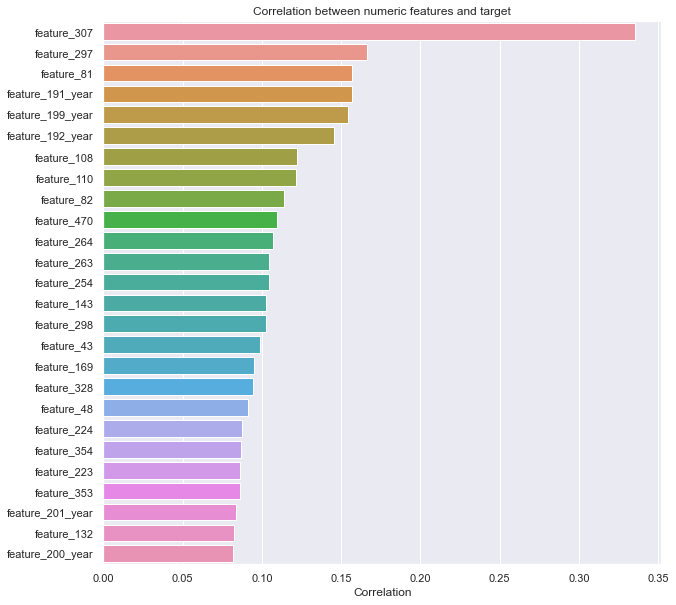

In [23]:
#Plot features which have more than 0.08 correlation with the target
plt.figure(figsize=(10,10))

#Plot - sorted correlations
sns.barplot(x=corr_df[corr_df>0.08],y=corr_df[corr_df>0.08].index).set_title('Correlation between numeric features and target')
plt.xlabel('Correlation')

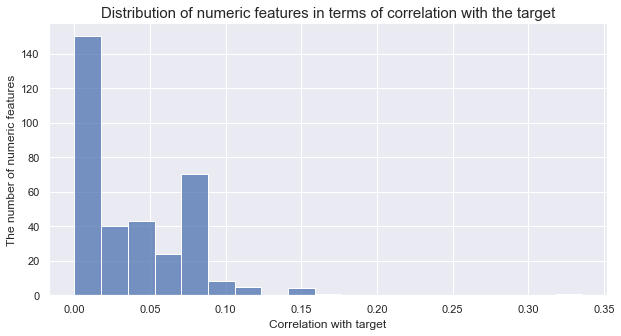

In [24]:
plt.figure(figsize=(10,5))
plt.xlabel('Correlation with target')
plt.ylabel('The number of numeric features')
sns.histplot(corr_df).set_title('Distribution of numeric features in terms of correlation with the target',size=15)
plt.show()

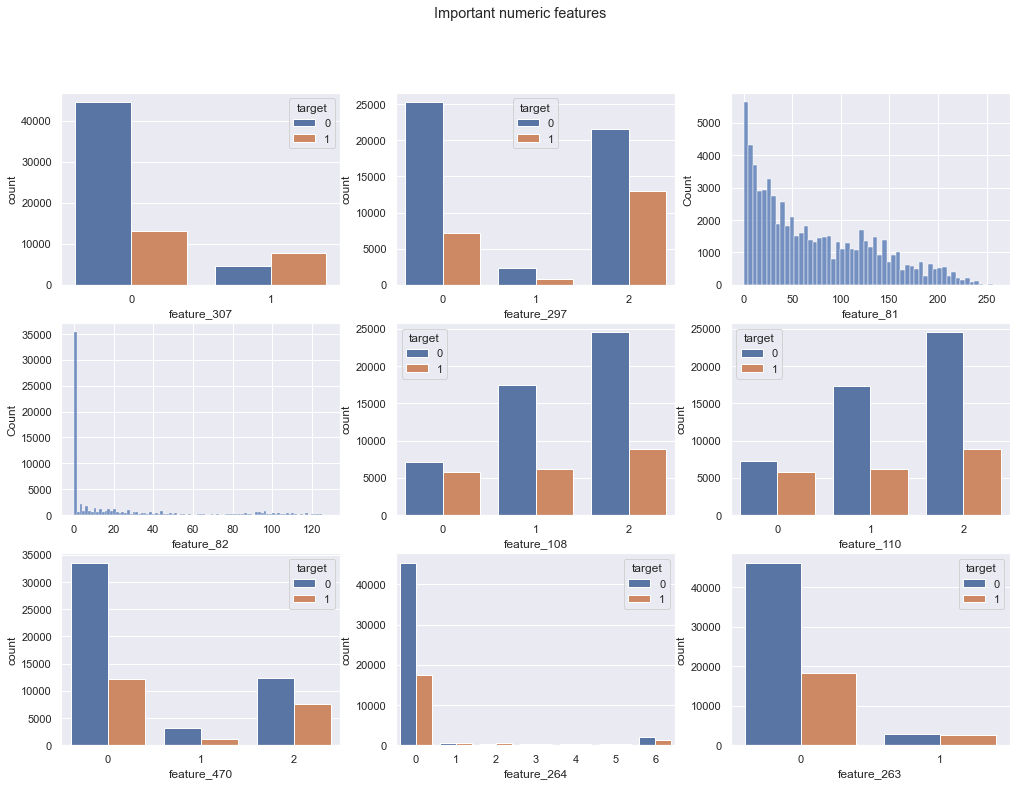

In [25]:
fig, ax = plt.subplots(3,3,figsize=(17,12))
sns.countplot(train_c.feature_307,hue=train_c.target, ax=ax[0][0])
sns.countplot(train_c.feature_297,hue=train_c.target, ax=ax[0][1])
sns.histplot(train_c.feature_81, ax=ax[0][2])
sns.histplot(train_c.feature_82, ax=ax[1][0])
sns.countplot(train_c.feature_108,hue=train_c.target, ax=ax[1][1])
sns.countplot(train_c.feature_110,hue=train_c.target, ax=ax[1][2])
sns.countplot(train_c.feature_470,hue=train_c.target, ax=ax[2][0])
sns.countplot(train_c.feature_264,hue=train_c.target, ax=ax[2][1])
sns.countplot(train_c.feature_263,hue=train_c.target, ax=ax[2][2])

plt.suptitle('Important numeric features')
plt.show()

In [26]:
#Taking sqrt of feature_81
train_c['feature_81_sqrt']= train_c.feature_81.apply(np.sqrt)
test_c['feature_81_sqrt']= test_c.feature_81.apply(np.sqrt)

#Binarization feature_82
train_c['feature_82_binary']= train_c['feature_82'].apply(lambda x: 0 if x==0 else 1)
test_c['feature_82_binary']= test_c['feature_82'].apply(lambda x: 0 if x==0 else 1)

#Multiplication of feature_307 and feature_82_binary
train_c['feature_82_307']= train_c['feature_307']*train_c['feature_82_binary']
test_c['feature_82_307']= test_c['feature_307']*test_c['feature_82_binary']

In [27]:
#Corr less than 0.002 with target
low_corr=list(corr_df[corr_df<0.002].index)

#Add to drop list
Features_toDrop+=low_corr
print(len(low_corr),' features added to drop list')

28  features added to drop list


In [28]:
tmp=[]
for col in train_c.columns:
    #If column contains one unique value
    if (( train_c[col].nunique() <=1 )):
        #add to list
        tmp.append(col)
#Filter dataframe
train[tmp]

,feature_55,feature_100,feature_149,feature_187,feature_188,feature_190,feature_227,feature_228,feature_248,feature_249,feature_252,feature_312,feature_313,feature_357,feature_358,feature_375,feature_377,feature_385,feature_389,feature_395,feature_397,feature_405,feature_409,feature_411,feature_412,feature_413,feature_419,feature_421,feature_425,feature_427,feature_432,feature_433,feature_445,feature_449,feature_451,feature_453,feature_455,feature_459,feature_461,feature_463,feature_465,feature_467,feature_469,feature_472,feature_474,feature_476,feature_478,feature_480,feature_482,feature_484,feature_487,feature_489,feature_491,feature_493,feature_495,feature_498,feature_500,feature_502,feature_505
0,C0,0,0,C0,C0,C0,0,0,C0,C1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,C0,0,0,C0,C0,C0,0,0,C0,C1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,C0,0,0,C0,C0,C0,0,0,C0,C1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,C0,0,0,C0,C0,C0,0,0,C0,C1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,C0,0,0,C0,C0,C0,0,0,C0,C1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,C0,0,0,C0,C0,C0,0,0,C0,C1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
69996,C0,0,0,C0,C0,C0,0,0,C0,C1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
69997,C0,0,0,C0,C0,C0,0,0,C0,C1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
69998,C0,0,0,C0,C0,C0,0,0,C0,C1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [29]:
#Add to drop list
Features_toDrop+=list(tmp)

print(len(tmp),' features added to drop list')

59  features added to drop list


In [30]:
def get_highly_correlated(df, features, threshold=0.5):
    corr_df = df[features].corr() # get correlations
    correlated_features = np.where(np.abs(corr_df) > threshold) # select ones above the abs threshold
    correlated_features = [(corr_df.iloc[x,y], x, y) for x, y in zip(*correlated_features) if x != y and x < y] # avoid duplication
    s_corr_list = sorted(correlated_features, key=lambda x: -abs(x[0])) # sort by correlation value
    if s_corr_list == []:
        print("There are no highly correlated features with correlation above", threshold)
    else:
        col1,col2,col3=list(),list(),list()
        for v, i, j in s_corr_list:
            col1.append(corr_df.index[i])
            col2.append(corr_df.columns[j])
            col3.append(v)
        col_list=[col1,col2,col3]
        return pd.DataFrame(col_list, index=['F1', 'F2','Correlation']).T.sort_values(by='Correlation',ascending=False)

In [31]:
F_corr_df= get_highly_correlated(train_c[Numeric_Features],Numeric_Features,threshold=0.9)
F_corr_df

,F1,F2,Correlation
0,feature_46,feature_140,1.0
520,feature_448,feature_464,1.0
511,feature_444,feature_503,1.0
513,feature_444,feature_506,1.0
514,feature_448,feature_450,1.0
...,...,...,...
447,feature_424,feature_497,-1.0
36,feature_374,feature_490,-1.0
40,feature_374,feature_497,-1.0
443,feature_424,feature_490,-1.0


In [32]:
#Using set() to get distinct features from the column F1
drop_F1=list( set(F_corr_df.F1[F_corr_df.Correlation>0.9]) ) + list( set(F_corr_df.F1[F_corr_df.Correlation<-0.9]) )

#Drop
Features_toDrop += drop_F1
print(len(drop_F1),' features added to drop list')

188  features added to drop list


In [33]:
Features_toDrop=list(set(Features_toDrop))

train_c.drop(Features_toDrop,axis=1,inplace=True)
test_c.drop(Features_toDrop,axis=1,inplace=True)

#Remove from Categorical_Features list
Categorical_Features = [e for e in Categorical_Features
                        if e not in Features_toDrop]
#Remove from Numeric features list
Numeric_Features=[e for e in Numeric_Features
                  if e not in Features_toDrop]

print(len(Features_toDrop),' Features dropped')

216  Features dropped


In [34]:
train_c.shape, test_c.shape

((70000, 269), (30000, 268))

In [35]:
#Create copy
train_e=train_c.copy()
test_e=test_c.copy()

for col in list(Categorical_Features):
    le = LabelEncoder()
    #fit encoder on train/test at the same time
    le.fit(pd.concat([train_e[col],test_e[col]], ignore_index=True))
    #transform 
    train_e[col]=le.transform(train_e[col])
    test_e[col]=le.transform(test_e[col])

In [36]:
toDrop=['target'] + ['feature_82','feature_192_year','feature_199_year','feature_200_year','feature_201_year']

#Variables
X=train_e.drop(toDrop,axis=1)
y=train_e['target']

X_train,X_valid,y_train,y_valid = train_test_split(X, y, test_size=0.2,random_state=18)

In [62]:
X.shape, y.shape

((70000, 263), (70000,))

In [37]:
import optuna
from optuna.integration import LightGBMPruningCallback

def objective(trial, X, y):
    param_grid = {
        
        # "device_type": trial.suggest_categorical("device_type", ['gpu']),
        "n_estimators": trial.suggest_int("n_estimators", 5000,20000,step=10),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.02, 0.1),
       # "num_leaves": trial.suggest_int("num_leaves", 10, 2000, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 1.0, 15.0),
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 1.0, 15.0),
        'scale_pos_weight': trial.suggest_float("scale_pos_weight", 0.1, 0.95, step=0.1),
        'subsample': trial.suggest_loguniform('subsample', 0.4, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0.2, 0.95, step=0.1),
        "min_child_weight": trial.suggest_float("min_child_weight", 1, 10, step=1),
        
        # 'task_type': trial.suggest_categorical('task_type', ['GPU']),
       
        #"bagging_freq": trial.suggest_int("bagging_freq", 0,10),
        #"feature_fraction": trial.suggest_float(
        #"feature_fraction", 0.2, 0.95, step=0.1
        #),
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=18)

    cv_scores = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = XGBClassifier( **param_grid)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            eval_metric="auc",
            early_stopping_rounds=200,
            verbose=200,

        )
        preds = model.predict_proba(X_test)
        cv_scores[idx] = roc_auc_score(y_test, preds[:,1])

    return np.mean(cv_scores)


#Start tuning
study = optuna.create_study(direction="maximize", study_name="LGBM Classifier")
func = lambda trial: objective(trial, X, y)
study.optimize(func, n_trials=20)

#Show best parameters
print(f"\tBest auc: {study.best_value:.5f}")
print(f"\tBest params:")
for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2022-03-28 14:26:36,041] A new study created in memory with name: LGBM Classifier


[0]	validation_0-auc:0.71864
[200]	validation_0-auc:0.78520
[400]	validation_0-auc:0.78489
[493]	validation_0-auc:0.78412
[0]	validation_0-auc:0.71199
[200]	validation_0-auc:0.78475
[400]	validation_0-auc:0.78576
[565]	validation_0-auc:0.78510
[0]	validation_0-auc:0.71346
[200]	validation_0-auc:0.78004
[400]	validation_0-auc:0.77890
[418]	validation_0-auc:0.77886
[0]	validation_0-auc:0.70472
[200]	validation_0-auc:0.78055
[400]	validation_0-auc:0.77972
[445]	validation_0-auc:0.77939
[0]	validation_0-auc:0.71779
[200]	validation_0-auc:0.78160
[400]	validation_0-auc:0.78084
[423]	validation_0-auc:0.78044


[I 2022-03-28 14:31:04,259] Trial 0 finished with value: 0.7830288495025144 and parameters: {'n_estimators': 18760, 'learning_rate': 0.05224086923788845, 'max_depth': 11, 'reg_alpha': 10.826639489453504, 'reg_lambda': 8.81222780654638, 'scale_pos_weight': 0.30000000000000004, 'subsample': 0.5392671604152012, 'colsample_bytree': 0.864800157943385, 'gamma': 0.2, 'min_child_weight': 9.0}. Best is trial 0 with value: 0.7830288495025144.


[0]	validation_0-auc:0.71848
[200]	validation_0-auc:0.78278
[400]	validation_0-auc:0.78675
[600]	validation_0-auc:0.78693
[695]	validation_0-auc:0.78687
[0]	validation_0-auc:0.71145
[200]	validation_0-auc:0.78201
[400]	validation_0-auc:0.78701
[600]	validation_0-auc:0.78771
[800]	validation_0-auc:0.78785
[904]	validation_0-auc:0.78775
[0]	validation_0-auc:0.71336
[200]	validation_0-auc:0.77694
[400]	validation_0-auc:0.78005
[600]	validation_0-auc:0.78024
[702]	validation_0-auc:0.78020
[0]	validation_0-auc:0.70488
[200]	validation_0-auc:0.77870
[400]	validation_0-auc:0.78144
[600]	validation_0-auc:0.78182
[789]	validation_0-auc:0.78163
[0]	validation_0-auc:0.71327
[200]	validation_0-auc:0.77995
[400]	validation_0-auc:0.78325
[600]	validation_0-auc:0.78357
[800]	validation_0-auc:0.78324
[815]	validation_0-auc:0.78323


[I 2022-03-28 14:36:08,484] Trial 1 finished with value: 0.78419554481533 and parameters: {'n_estimators': 17760, 'learning_rate': 0.0303636849608123, 'max_depth': 9, 'reg_alpha': 6.471221387171429, 'reg_lambda': 9.814769319650274, 'scale_pos_weight': 0.2, 'subsample': 0.7256600141553206, 'colsample_bytree': 0.5978438235941709, 'gamma': 0.9, 'min_child_weight': 6.0}. Best is trial 1 with value: 0.78419554481533.


[0]	validation_0-auc:0.74261
[200]	validation_0-auc:0.78579
[400]	validation_0-auc:0.78577
[444]	validation_0-auc:0.78533
[0]	validation_0-auc:0.74253
[200]	validation_0-auc:0.78605
[400]	validation_0-auc:0.78679
[552]	validation_0-auc:0.78563
[0]	validation_0-auc:0.74379
[200]	validation_0-auc:0.77908
[400]	validation_0-auc:0.77847
[435]	validation_0-auc:0.77801
[0]	validation_0-auc:0.74199
[200]	validation_0-auc:0.78123
[400]	validation_0-auc:0.78100
[445]	validation_0-auc:0.78069
[0]	validation_0-auc:0.74490
[200]	validation_0-auc:0.78205
[400]	validation_0-auc:0.78256
[543]	validation_0-auc:0.78137


[I 2022-03-28 14:40:59,532] Trial 2 finished with value: 0.7835236927986815 and parameters: {'n_estimators': 11930, 'learning_rate': 0.032379800539672, 'max_depth': 11, 'reg_alpha': 8.33523239976737, 'reg_lambda': 4.382560762600932, 'scale_pos_weight': 0.7000000000000001, 'subsample': 0.5647054154867663, 'colsample_bytree': 0.733342191404933, 'gamma': 0.8, 'min_child_weight': 7.0}. Best is trial 1 with value: 0.78419554481533.


[0]	validation_0-auc:0.71487
[200]	validation_0-auc:0.78663
[400]	validation_0-auc:0.78649
[460]	validation_0-auc:0.78625
[0]	validation_0-auc:0.70015
[200]	validation_0-auc:0.78623
[400]	validation_0-auc:0.78688
[541]	validation_0-auc:0.78600
[0]	validation_0-auc:0.71159
[200]	validation_0-auc:0.77951
[400]	validation_0-auc:0.77872
[462]	validation_0-auc:0.77831
[0]	validation_0-auc:0.70593
[200]	validation_0-auc:0.78100
[400]	validation_0-auc:0.78077
[439]	validation_0-auc:0.78054
[0]	validation_0-auc:0.71119
[200]	validation_0-auc:0.78201
[400]	validation_0-auc:0.78181
[421]	validation_0-auc:0.78168


[I 2022-03-28 14:43:10,362] Trial 3 finished with value: 0.7834377644374291 and parameters: {'n_estimators': 18470, 'learning_rate': 0.08092342692079729, 'max_depth': 5, 'reg_alpha': 3.402955998274029, 'reg_lambda': 8.967261940715424, 'scale_pos_weight': 0.1, 'subsample': 0.9355815061196043, 'colsample_bytree': 0.8779882201345899, 'gamma': 0.2, 'min_child_weight': 7.0}. Best is trial 1 with value: 0.78419554481533.


[0]	validation_0-auc:0.71839
[200]	validation_0-auc:0.78443
[400]	validation_0-auc:0.78695
[600]	validation_0-auc:0.78726
[800]	validation_0-auc:0.78716
[919]	validation_0-auc:0.78707
[0]	validation_0-auc:0.71194
[200]	validation_0-auc:0.78320
[400]	validation_0-auc:0.78698
[600]	validation_0-auc:0.78796
[800]	validation_0-auc:0.78802
[945]	validation_0-auc:0.78775
[0]	validation_0-auc:0.71412
[200]	validation_0-auc:0.77801
[400]	validation_0-auc:0.78021
[600]	validation_0-auc:0.78013
[678]	validation_0-auc:0.78005
[0]	validation_0-auc:0.71002
[200]	validation_0-auc:0.78013
[400]	validation_0-auc:0.78210
[600]	validation_0-auc:0.78209
[739]	validation_0-auc:0.78199
[0]	validation_0-auc:0.71553
[200]	validation_0-auc:0.78085
[400]	validation_0-auc:0.78305
[600]	validation_0-auc:0.78281
[692]	validation_0-auc:0.78281


[I 2022-03-28 14:48:51,094] Trial 4 finished with value: 0.7842767315725145 and parameters: {'n_estimators': 15450, 'learning_rate': 0.032203094824770684, 'max_depth': 11, 'reg_alpha': 14.67614470470487, 'reg_lambda': 2.3620212276696124, 'scale_pos_weight': 0.30000000000000004, 'subsample': 0.7649083313853297, 'colsample_bytree': 0.5995682669111249, 'gamma': 0.9, 'min_child_weight': 5.0}. Best is trial 4 with value: 0.7842767315725145.


[0]	validation_0-auc:0.72020
[200]	validation_0-auc:0.78160
[400]	validation_0-auc:0.78708
[600]	validation_0-auc:0.78808
[800]	validation_0-auc:0.78811
[1000]	validation_0-auc:0.78785
[1039]	validation_0-auc:0.78783
[0]	validation_0-auc:0.71346
[200]	validation_0-auc:0.78044
[400]	validation_0-auc:0.78663
[600]	validation_0-auc:0.78841
[800]	validation_0-auc:0.78889
[1000]	validation_0-auc:0.78894
[1064]	validation_0-auc:0.78876
[0]	validation_0-auc:0.71519
[200]	validation_0-auc:0.77494
[400]	validation_0-auc:0.77985
[600]	validation_0-auc:0.78059
[800]	validation_0-auc:0.78043
[852]	validation_0-auc:0.78037
[0]	validation_0-auc:0.70998
[200]	validation_0-auc:0.77732
[400]	validation_0-auc:0.78194
[600]	validation_0-auc:0.78268
[800]	validation_0-auc:0.78264
[856]	validation_0-auc:0.78259
[0]	validation_0-auc:0.71757
[200]	validation_0-auc:0.77877
[400]	validation_0-auc:0.78348
[600]	validation_0-auc:0.78425
[800]	validation_0-auc:0.78440
[886]	validation_0-auc:0.78436


[I 2022-03-28 14:53:30,682] Trial 5 finished with value: 0.7850509047869206 and parameters: {'n_estimators': 19420, 'learning_rate': 0.02191504717128414, 'max_depth': 6, 'reg_alpha': 6.699181986680222, 'reg_lambda': 13.858335809216376, 'scale_pos_weight': 0.4, 'subsample': 0.7193555476858599, 'colsample_bytree': 0.6927278785131706, 'gamma': 0.30000000000000004, 'min_child_weight': 4.0}. Best is trial 5 with value: 0.7850509047869206.


[0]	validation_0-auc:0.74478
[200]	validation_0-auc:0.78368
[301]	validation_0-auc:0.78256
[0]	validation_0-auc:0.73865
[200]	validation_0-auc:0.78305
[318]	validation_0-auc:0.77949
[0]	validation_0-auc:0.73986
[200]	validation_0-auc:0.77407
[304]	validation_0-auc:0.77260
[0]	validation_0-auc:0.73266
[200]	validation_0-auc:0.77819
[316]	validation_0-auc:0.77363
[0]	validation_0-auc:0.74220
[200]	validation_0-auc:0.77867
[299]	validation_0-auc:0.77597


[I 2022-03-28 14:55:59,537] Trial 6 finished with value: 0.7815979382943845 and parameters: {'n_estimators': 11160, 'learning_rate': 0.06246080519833448, 'max_depth': 8, 'reg_alpha': 3.704268837354496, 'reg_lambda': 1.0002186501942387, 'scale_pos_weight': 0.6, 'subsample': 0.4141499050578003, 'colsample_bytree': 0.961999637785986, 'gamma': 0.8, 'min_child_weight': 2.0}. Best is trial 5 with value: 0.7850509047869206.


[0]	validation_0-auc:0.74408
[200]	validation_0-auc:0.78473
[400]	validation_0-auc:0.78658
[600]	validation_0-auc:0.78568
[601]	validation_0-auc:0.78569
[0]	validation_0-auc:0.73589
[200]	validation_0-auc:0.78313
[400]	validation_0-auc:0.78565
[600]	validation_0-auc:0.78479
[616]	validation_0-auc:0.78465
[0]	validation_0-auc:0.73602
[200]	validation_0-auc:0.77759
[400]	validation_0-auc:0.77878
[529]	validation_0-auc:0.77796
[0]	validation_0-auc:0.73201
[200]	validation_0-auc:0.78002
[400]	validation_0-auc:0.78174
[600]	validation_0-auc:0.78063
[604]	validation_0-auc:0.78058
[0]	validation_0-auc:0.74062
[200]	validation_0-auc:0.78146
[400]	validation_0-auc:0.78231
[595]	validation_0-auc:0.78091


[I 2022-03-28 15:00:23,874] Trial 7 finished with value: 0.7831895925098661 and parameters: {'n_estimators': 6380, 'learning_rate': 0.02377174788896936, 'max_depth': 11, 'reg_alpha': 7.873506680043851, 'reg_lambda': 1.6749431679941735, 'scale_pos_weight': 0.8, 'subsample': 0.4212159512915641, 'colsample_bytree': 0.6473311434323635, 'gamma': 0.8, 'min_child_weight': 8.0}. Best is trial 5 with value: 0.7850509047869206.


[0]	validation_0-auc:0.71801
[200]	validation_0-auc:0.78603
[400]	validation_0-auc:0.78619
[513]	validation_0-auc:0.78611
[0]	validation_0-auc:0.70242
[200]	validation_0-auc:0.78501
[400]	validation_0-auc:0.78609
[511]	validation_0-auc:0.78591
[0]	validation_0-auc:0.71206
[200]	validation_0-auc:0.77883
[400]	validation_0-auc:0.77825
[494]	validation_0-auc:0.77804
[0]	validation_0-auc:0.70449
[200]	validation_0-auc:0.77994
[400]	validation_0-auc:0.78016
[557]	validation_0-auc:0.77901
[0]	validation_0-auc:0.71437
[200]	validation_0-auc:0.78151
[400]	validation_0-auc:0.78156
[528]	validation_0-auc:0.78126


[I 2022-03-28 15:02:41,594] Trial 8 finished with value: 0.7829063014534727 and parameters: {'n_estimators': 7830, 'learning_rate': 0.07004673581222176, 'max_depth': 5, 'reg_alpha': 6.691658992062094, 'reg_lambda': 1.200072462892337, 'scale_pos_weight': 0.2, 'subsample': 0.4296059427718077, 'colsample_bytree': 0.7681169130102588, 'gamma': 0.8, 'min_child_weight': 6.0}. Best is trial 5 with value: 0.7850509047869206.


[0]	validation_0-auc:0.64402
[200]	validation_0-auc:0.78627
[400]	validation_0-auc:0.78582
[454]	validation_0-auc:0.78553
[0]	validation_0-auc:0.63883
[200]	validation_0-auc:0.78579
[400]	validation_0-auc:0.78592
[600]	validation_0-auc:0.78556
[651]	validation_0-auc:0.78539
[0]	validation_0-auc:0.63865
[200]	validation_0-auc:0.77819
[400]	validation_0-auc:0.77812
[499]	validation_0-auc:0.77748
[0]	validation_0-auc:0.63916
[200]	validation_0-auc:0.78051
[400]	validation_0-auc:0.78053
[462]	validation_0-auc:0.78022
[0]	validation_0-auc:0.64231
[200]	validation_0-auc:0.78073
[400]	validation_0-auc:0.78063
[434]	validation_0-auc:0.78022


[I 2022-03-28 15:05:20,122] Trial 9 finished with value: 0.7827586307231045 and parameters: {'n_estimators': 12440, 'learning_rate': 0.08364804705019609, 'max_depth': 9, 'reg_alpha': 4.564135945725569, 'reg_lambda': 3.583460807902213, 'scale_pos_weight': 0.1, 'subsample': 0.4484890580134875, 'colsample_bytree': 0.5438399119190607, 'gamma': 0.5, 'min_child_weight': 2.0}. Best is trial 5 with value: 0.7850509047869206.


[0]	validation_0-auc:0.73920
[200]	validation_0-auc:0.77258
[400]	validation_0-auc:0.78212
[600]	validation_0-auc:0.78539
[800]	validation_0-auc:0.78655
[1000]	validation_0-auc:0.78709
[1200]	validation_0-auc:0.78746
[1400]	validation_0-auc:0.78777
[1600]	validation_0-auc:0.78797
[1800]	validation_0-auc:0.78802
[2000]	validation_0-auc:0.78806
[2200]	validation_0-auc:0.78826
[2400]	validation_0-auc:0.78828
[2589]	validation_0-auc:0.78827
[0]	validation_0-auc:0.73247
[200]	validation_0-auc:0.77112
[400]	validation_0-auc:0.77996
[600]	validation_0-auc:0.78325
[800]	validation_0-auc:0.78499
[1000]	validation_0-auc:0.78607
[1200]	validation_0-auc:0.78675
[1400]	validation_0-auc:0.78702
[1600]	validation_0-auc:0.78743
[1800]	validation_0-auc:0.78777
[2000]	validation_0-auc:0.78788
[2200]	validation_0-auc:0.78800
[2400]	validation_0-auc:0.78813
[2600]	validation_0-auc:0.78808
[2700]	validation_0-auc:0.78806
[0]	validation_0-auc:0.73493
[200]	validation_0-auc:0.76789
[400]	validation_0-auc:0.7

[I 2022-03-28 15:12:20,403] Trial 10 finished with value: 0.7847615277368594 and parameters: {'n_estimators': 15250, 'learning_rate': 0.020729918875957445, 'max_depth': 3, 'reg_alpha': 1.3592781040548156, 'reg_lambda': 13.622138369640732, 'scale_pos_weight': 0.5, 'subsample': 0.9841561519973565, 'colsample_bytree': 0.6961309047965714, 'gamma': 0.4, 'min_child_weight': 4.0}. Best is trial 5 with value: 0.7850509047869206.


[0]	validation_0-auc:0.73920
[200]	validation_0-auc:0.77245
[400]	validation_0-auc:0.78194
[600]	validation_0-auc:0.78509
[800]	validation_0-auc:0.78627
[1000]	validation_0-auc:0.78689
[1200]	validation_0-auc:0.78734
[1400]	validation_0-auc:0.78762
[1600]	validation_0-auc:0.78782
[1800]	validation_0-auc:0.78798
[2000]	validation_0-auc:0.78808
[2200]	validation_0-auc:0.78823
[2400]	validation_0-auc:0.78818
[2430]	validation_0-auc:0.78814
[0]	validation_0-auc:0.73247
[200]	validation_0-auc:0.77108
[400]	validation_0-auc:0.77982
[600]	validation_0-auc:0.78280
[800]	validation_0-auc:0.78456
[1000]	validation_0-auc:0.78559
[1200]	validation_0-auc:0.78625
[1400]	validation_0-auc:0.78670
[1600]	validation_0-auc:0.78719
[1800]	validation_0-auc:0.78741
[2000]	validation_0-auc:0.78758
[2200]	validation_0-auc:0.78770
[2400]	validation_0-auc:0.78773
[2600]	validation_0-auc:0.78770
[2679]	validation_0-auc:0.78772
[0]	validation_0-auc:0.73493
[200]	validation_0-auc:0.76770
[400]	validation_0-auc:0.7

[I 2022-03-28 15:18:42,664] Trial 11 finished with value: 0.7845247212495422 and parameters: {'n_estimators': 15590, 'learning_rate': 0.020451126035636986, 'max_depth': 3, 'reg_alpha': 1.1396899398857214, 'reg_lambda': 14.116617110867505, 'scale_pos_weight': 0.5, 'subsample': 0.9923750955263775, 'colsample_bytree': 0.710722396858947, 'gamma': 0.4, 'min_child_weight': 4.0}. Best is trial 5 with value: 0.7850509047869206.


[0]	validation_0-auc:0.74005
[200]	validation_0-auc:0.77697
[400]	validation_0-auc:0.78430
[600]	validation_0-auc:0.78660
[800]	validation_0-auc:0.78755
[1000]	validation_0-auc:0.78808
[1200]	validation_0-auc:0.78842
[1400]	validation_0-auc:0.78845
[1600]	validation_0-auc:0.78848
[1670]	validation_0-auc:0.78847
[0]	validation_0-auc:0.73181
[200]	validation_0-auc:0.77466
[400]	validation_0-auc:0.78251
[600]	validation_0-auc:0.78534
[800]	validation_0-auc:0.78680
[1000]	validation_0-auc:0.78765
[1200]	validation_0-auc:0.78805
[1400]	validation_0-auc:0.78834
[1600]	validation_0-auc:0.78850
[1800]	validation_0-auc:0.78852
[1946]	validation_0-auc:0.78854
[0]	validation_0-auc:0.73780
[200]	validation_0-auc:0.77087
[400]	validation_0-auc:0.77729
[600]	validation_0-auc:0.77933
[800]	validation_0-auc:0.78032
[1000]	validation_0-auc:0.78090
[1200]	validation_0-auc:0.78120
[1400]	validation_0-auc:0.78129
[1600]	validation_0-auc:0.78140
[1800]	validation_0-auc:0.78146
[1937]	validation_0-auc:0.781

[I 2022-03-28 15:24:01,612] Trial 12 finished with value: 0.785024095861445 and parameters: {'n_estimators': 15460, 'learning_rate': 0.025711479039386295, 'max_depth': 3, 'reg_alpha': 1.560119185590355, 'reg_lambda': 14.605180735802525, 'scale_pos_weight': 0.5, 'subsample': 0.8242544625765922, 'colsample_bytree': 0.8048791225317607, 'gamma': 0.4, 'min_child_weight': 4.0}. Best is trial 5 with value: 0.7850509047869206.


[0]	validation_0-auc:0.74447
[200]	validation_0-auc:0.78667
[400]	validation_0-auc:0.78838
[600]	validation_0-auc:0.78849
[708]	validation_0-auc:0.78813
[0]	validation_0-auc:0.73350
[200]	validation_0-auc:0.78592
[400]	validation_0-auc:0.78882
[600]	validation_0-auc:0.78884
[660]	validation_0-auc:0.78880
[0]	validation_0-auc:0.74233
[200]	validation_0-auc:0.77884
[400]	validation_0-auc:0.78002
[506]	validation_0-auc:0.77980
[0]	validation_0-auc:0.74448
[200]	validation_0-auc:0.78078
[400]	validation_0-auc:0.78244
[600]	validation_0-auc:0.78207
[658]	validation_0-auc:0.78186
[0]	validation_0-auc:0.74741
[200]	validation_0-auc:0.78159
[400]	validation_0-auc:0.78282
[600]	validation_0-auc:0.78271
[625]	validation_0-auc:0.78249


[I 2022-03-28 15:26:54,642] Trial 13 finished with value: 0.7847514236544113 and parameters: {'n_estimators': 19860, 'learning_rate': 0.04024861842020142, 'max_depth': 5, 'reg_alpha': 2.262954159441816, 'reg_lambda': 5.326803982009336, 'scale_pos_weight': 0.4, 'subsample': 0.7867667259395573, 'colsample_bytree': 0.8171918355661842, 'gamma': 0.30000000000000004, 'min_child_weight': 3.0}. Best is trial 5 with value: 0.7850509047869206.


[0]	validation_0-auc:0.74782
[200]	validation_0-auc:0.78636
[400]	validation_0-auc:0.78830
[600]	validation_0-auc:0.78857
[758]	validation_0-auc:0.78800
[0]	validation_0-auc:0.75068
[200]	validation_0-auc:0.78447
[400]	validation_0-auc:0.78826
[600]	validation_0-auc:0.78870
[736]	validation_0-auc:0.78851
[0]	validation_0-auc:0.74640
[200]	validation_0-auc:0.77856
[400]	validation_0-auc:0.78058
[600]	validation_0-auc:0.78108
[767]	validation_0-auc:0.78023
[0]	validation_0-auc:0.74716
[200]	validation_0-auc:0.78011
[400]	validation_0-auc:0.78236
[600]	validation_0-auc:0.78203
[612]	validation_0-auc:0.78202
[0]	validation_0-auc:0.75161
[200]	validation_0-auc:0.78216
[400]	validation_0-auc:0.78417
[600]	validation_0-auc:0.78453
[746]	validation_0-auc:0.78439


[I 2022-03-28 15:31:30,126] Trial 14 finished with value: 0.7852323684370296 and parameters: {'n_estimators': 16380, 'learning_rate': 0.02581295645339206, 'max_depth': 6, 'reg_alpha': 2.317849775820173, 'reg_lambda': 6.356573679923302, 'scale_pos_weight': 0.9, 'subsample': 0.6932899264939789, 'colsample_bytree': 0.9816945205165654, 'gamma': 0.6000000000000001, 'min_child_weight': 1.0}. Best is trial 14 with value: 0.7852323684370296.


[0]	validation_0-auc:0.74940
[200]	validation_0-auc:0.78758
[400]	validation_0-auc:0.78866
[533]	validation_0-auc:0.78753
[0]	validation_0-auc:0.74828
[200]	validation_0-auc:0.78647
[400]	validation_0-auc:0.78840
[553]	validation_0-auc:0.78767
[0]	validation_0-auc:0.74526
[200]	validation_0-auc:0.78023
[400]	validation_0-auc:0.78030
[487]	validation_0-auc:0.77998
[0]	validation_0-auc:0.74622
[200]	validation_0-auc:0.78178
[400]	validation_0-auc:0.78216
[484]	validation_0-auc:0.78135
[0]	validation_0-auc:0.74945
[200]	validation_0-auc:0.78315
[400]	validation_0-auc:0.78379
[529]	validation_0-auc:0.78326


[I 2022-03-28 15:34:50,161] Trial 15 finished with value: 0.7849096512447155 and parameters: {'n_estimators': 16950, 'learning_rate': 0.04000710566837191, 'max_depth': 6, 'reg_alpha': 2.278681150463285, 'reg_lambda': 6.888613871722431, 'scale_pos_weight': 0.9, 'subsample': 0.6477142978928015, 'colsample_bytree': 0.9875527656367786, 'gamma': 0.6000000000000001, 'min_child_weight': 1.0}. Best is trial 14 with value: 0.7852323684370296.


[0]	validation_0-auc:0.75297
[200]	validation_0-auc:0.78728
[400]	validation_0-auc:0.78873
[600]	validation_0-auc:0.78770
[603]	validation_0-auc:0.78773
[0]	validation_0-auc:0.74834
[200]	validation_0-auc:0.78548
[400]	validation_0-auc:0.78816
[600]	validation_0-auc:0.78793
[0]	validation_0-auc:0.74567
[200]	validation_0-auc:0.77936
[400]	validation_0-auc:0.78099
[600]	validation_0-auc:0.78040
[603]	validation_0-auc:0.78041
[0]	validation_0-auc:0.74669
[200]	validation_0-auc:0.78059
[400]	validation_0-auc:0.78138
[523]	validation_0-auc:0.78091
[0]	validation_0-auc:0.74928
[200]	validation_0-auc:0.78219
[400]	validation_0-auc:0.78367
[600]	validation_0-auc:0.78375
[800]	validation_0-auc:0.78320
[835]	validation_0-auc:0.78314


[I 2022-03-28 15:39:16,736] Trial 16 finished with value: 0.7848004619449296 and parameters: {'n_estimators': 9330, 'learning_rate': 0.026555486229047843, 'max_depth': 7, 'reg_alpha': 2.442327722924518, 'reg_lambda': 3.162849521233599, 'scale_pos_weight': 0.9, 'subsample': 0.6499876805460247, 'colsample_bytree': 0.8979903662490458, 'gamma': 0.6000000000000001, 'min_child_weight': 1.0}. Best is trial 14 with value: 0.7852323684370296.


[0]	validation_0-auc:0.74420
[200]	validation_0-auc:0.78198
[285]	validation_0-auc:0.77886
[0]	validation_0-auc:0.74551
[200]	validation_0-auc:0.78267
[292]	validation_0-auc:0.78052
[0]	validation_0-auc:0.74368
[200]	validation_0-auc:0.77560
[281]	validation_0-auc:0.77270
[0]	validation_0-auc:0.74223
[200]	validation_0-auc:0.77765
[263]	validation_0-auc:0.77641
[0]	validation_0-auc:0.74469
[200]	validation_0-auc:0.77954
[298]	validation_0-auc:0.77720


[I 2022-03-28 15:41:19,948] Trial 17 finished with value: 0.78264505170044 and parameters: {'n_estimators': 14140, 'learning_rate': 0.0999986453305042, 'max_depth': 7, 'reg_alpha': 5.070678034659959, 'reg_lambda': 6.160307801888118, 'scale_pos_weight': 0.7000000000000001, 'subsample': 0.5872965898900459, 'colsample_bytree': 0.9379622434003935, 'gamma': 0.5, 'min_child_weight': 10.0}. Best is trial 14 with value: 0.7852323684370296.


[0]	validation_0-auc:0.74540
[200]	validation_0-auc:0.78759
[400]	validation_0-auc:0.78793
[553]	validation_0-auc:0.78725
[0]	validation_0-auc:0.73459
[200]	validation_0-auc:0.78688
[400]	validation_0-auc:0.78844
[600]	validation_0-auc:0.78819
[631]	validation_0-auc:0.78779
[0]	validation_0-auc:0.74133
[200]	validation_0-auc:0.78041
[399]	validation_0-auc:0.77943
[0]	validation_0-auc:0.73974
[200]	validation_0-auc:0.78198
[400]	validation_0-auc:0.78152
[478]	validation_0-auc:0.78101
[0]	validation_0-auc:0.74543
[200]	validation_0-auc:0.78328
[400]	validation_0-auc:0.78338
[486]	validation_0-auc:0.78296


[I 2022-03-28 15:43:48,317] Trial 18 finished with value: 0.7846907475722259 and parameters: {'n_estimators': 17130, 'learning_rate': 0.045445427561264656, 'max_depth': 6, 'reg_alpha': 2.6575855998138165, 'reg_lambda': 10.703778393371675, 'scale_pos_weight': 0.7000000000000001, 'subsample': 0.6927284595387414, 'colsample_bytree': 0.6699867539835433, 'gamma': 0.7, 'min_child_weight': 2.0}. Best is trial 14 with value: 0.7852323684370296.


[0]	validation_0-auc:0.74415
[200]	validation_0-auc:0.77972
[400]	validation_0-auc:0.78585
[600]	validation_0-auc:0.78756
[800]	validation_0-auc:0.78835
[1000]	validation_0-auc:0.78846
[1200]	validation_0-auc:0.78862
[1334]	validation_0-auc:0.78861
[0]	validation_0-auc:0.73430
[200]	validation_0-auc:0.77743
[400]	validation_0-auc:0.78470
[600]	validation_0-auc:0.78711
[800]	validation_0-auc:0.78817
[1000]	validation_0-auc:0.78869
[1200]	validation_0-auc:0.78902
[1400]	validation_0-auc:0.78926
[1600]	validation_0-auc:0.78932
[1628]	validation_0-auc:0.78926
[0]	validation_0-auc:0.74270
[200]	validation_0-auc:0.77261
[400]	validation_0-auc:0.77849
[600]	validation_0-auc:0.78013
[800]	validation_0-auc:0.78061
[1000]	validation_0-auc:0.78115
[1200]	validation_0-auc:0.78122
[1400]	validation_0-auc:0.78113
[1493]	validation_0-auc:0.78102
[0]	validation_0-auc:0.74397
[200]	validation_0-auc:0.77478
[400]	validation_0-auc:0.78068
[600]	validation_0-auc:0.78243
[800]	validation_0-auc:0.78316
[100

[I 2022-03-28 15:49:10,691] Trial 19 finished with value: 0.785260932085537 and parameters: {'n_estimators': 19760, 'learning_rate': 0.023320267188641743, 'max_depth': 4, 'reg_alpha': 1.6880360385857955, 'reg_lambda': 7.431983629519588, 'scale_pos_weight': 0.4, 'subsample': 0.8684161015716424, 'colsample_bytree': 0.7875412265780093, 'gamma': 0.6000000000000001, 'min_child_weight': 5.0}. Best is trial 19 with value: 0.785260932085537.


	Best auc: 0.78526
	Best params:
		n_estimators: 19760
		learning_rate: 0.023320267188641743
		max_depth: 4
		reg_alpha: 1.6880360385857955
		reg_lambda: 7.431983629519588
		scale_pos_weight: 0.4
		subsample: 0.8684161015716424
		colsample_bytree: 0.7875412265780093
		gamma: 0.6000000000000001
		min_child_weight: 5.0


In [51]:
# Parameter grids
LGBM_params = {
    'n_estimators': 10000,
    'learning_rate': 0.01346129943895438,
    'num_leaves': 1230,
    'max_depth': 5,
    'lambda_l1': 9.014424962435049,
    'lambda_l2': 5.09941903202415,
    'min_child_samples': 56,
    'subsample': 0.8210241479916653,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'feature_fraction': 0.6000000000000001,
}
LGBM_params = study.best_params

CATBOOST_params = {
    'subsample': 0.50,
    'learning_rate': 0.03,
    "max_depth": 6,
    "min_data_in_leaf": 50,
    "colsample_bylevel": 0.5,
    'random_state':42,
    'num_boost_round': 2000,
    'l2_leaf_reg': 1.0,
    'eval_metric': "AUC",
}

XGB_params = {
    'n_estimators': 14140,
    'learning_rate': 0.0111538499996725174,
    'max_depth': 4,
    'reg_alpha': 2.9735993984217104,
    'reg_lambda': 2.214625977393439,
    'scale_pos_weight': 0.9,
    'subsample': 0.7768428006197691,
    'gamma': 0.5
}

#LGBM
LGBM = LGBMClassifier(**LGBM_params)

#Catboost
CATBOOST = CatBoostClassifier(**CATBOOST_params)

#XGBoost
XGB = XGBClassifier(**XGB_params)

In [52]:
#Returns validation score
def get_val_score(model):
    val_pred = model.predict_proba(X_valid)
    return roc_auc_score(y_valid,val_pred[:,1])

In [53]:
XGB.fit(X_train,y_train,
         eval_set=[(X_valid, y_valid)],
         early_stopping_rounds=200,verbose=100,eval_metric='auc')
#Get score
print("="*20)
print("LGBM Validation AUC : ", get_val_score(XGB))

[0]	validation_0-auc:0.74590
[100]	validation_0-auc:0.76266
[200]	validation_0-auc:0.76919
[300]	validation_0-auc:0.77427
[400]	validation_0-auc:0.77722
[500]	validation_0-auc:0.77922
[600]	validation_0-auc:0.78057
[700]	validation_0-auc:0.78152
[800]	validation_0-auc:0.78228
[900]	validation_0-auc:0.78277
[1000]	validation_0-auc:0.78317
[1100]	validation_0-auc:0.78360
[1200]	validation_0-auc:0.78390
[1300]	validation_0-auc:0.78405
[1400]	validation_0-auc:0.78433
[1500]	validation_0-auc:0.78448
[1600]	validation_0-auc:0.78467
[1700]	validation_0-auc:0.78481
[1800]	validation_0-auc:0.78491
[1900]	validation_0-auc:0.78497
[2000]	validation_0-auc:0.78504
[2100]	validation_0-auc:0.78505
[2200]	validation_0-auc:0.78516
[2300]	validation_0-auc:0.78514
[2400]	validation_0-auc:0.78509
[2419]	validation_0-auc:0.78512
LGBM Validation AUC :  0.7851942878111431


Text(0.5, 1.0, 'XGBoost Feature importance')

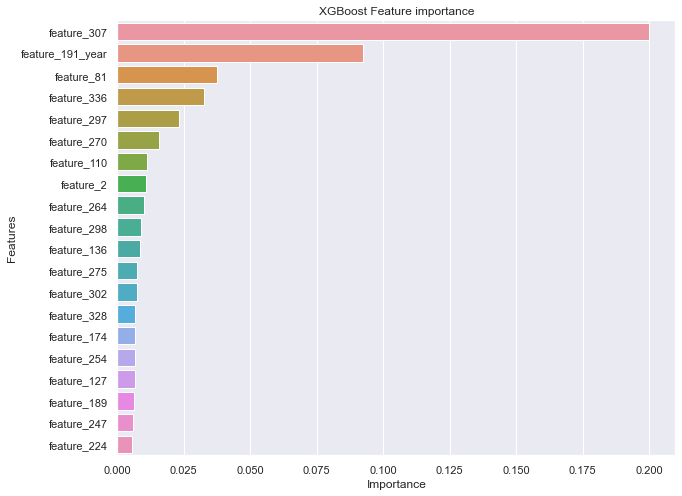

In [54]:
FI=pd.DataFrame({'Features':X.columns,'Importance':XGB.feature_importances_})
FI=FI.sort_values(by='Importance',ascending=False)[:20]
#plot
plt.figure(figsize=(10,8))
sns.barplot(x=FI.Importance,y=FI.Features).set_title('XGBoost Feature importance')

In [55]:
LGBM.fit(X_train,y_train,
         eval_set=[(X_valid, y_valid)],
         early_stopping_rounds=200,verbose=100,eval_metric='auc')
#Get score
print("="*20)
print("LGBM Validation AUC : ", get_val_score(LGBM))

[LightGBM] [Warning] Unknown parameter: gamma
[100]	valid_0's auc: 0.768585	valid_0's binary_logloss: 0.561135
[200]	valid_0's auc: 0.775804	valid_0's binary_logloss: 0.562821
LGBM Validation AUC :  0.7630112409026971


Text(0.5, 1.0, 'LGBM Feature importance')

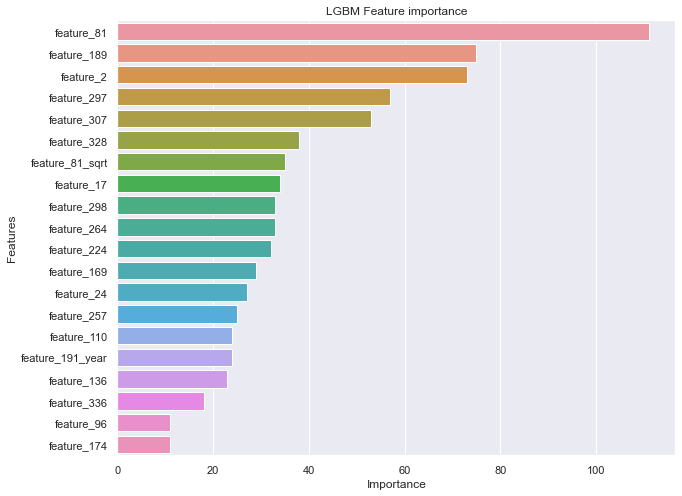

In [56]:
FI=pd.DataFrame({'Features':X.columns,'Importance':LGBM.feature_importances_})
FI=FI.sort_values(by='Importance',ascending=False)[:20]
#plot
plt.figure(figsize=(10,8))
sns.barplot(x=FI.Importance,y=FI.Features).set_title('LGBM Feature importance')

In [57]:
CATBOOST.fit(X_train,y_train,
             eval_set=[(X_valid, y_valid)],
             cat_features=Categorical_Features,
             early_stopping_rounds=200,verbose=100)
#Get score
print("="*20)
print("CATBOOST Validation AUC : ", get_val_score(CATBOOST))

0:	test: 0.7495993	best: 0.7495993 (0)	total: 102ms	remaining: 3m 23s
100:	test: 0.7754393	best: 0.7754393 (100)	total: 11.4s	remaining: 3m 34s
200:	test: 0.7797846	best: 0.7797846 (200)	total: 23.2s	remaining: 3m 27s
300:	test: 0.7817600	best: 0.7817673 (299)	total: 34.7s	remaining: 3m 15s
400:	test: 0.7830228	best: 0.7830228 (400)	total: 46.1s	remaining: 3m 3s
500:	test: 0.7839574	best: 0.7839574 (500)	total: 57.2s	remaining: 2m 51s
600:	test: 0.7844408	best: 0.7844537 (596)	total: 1m 8s	remaining: 2m 39s
700:	test: 0.7846162	best: 0.7846206 (672)	total: 1m 19s	remaining: 2m 27s
800:	test: 0.7849630	best: 0.7849667 (797)	total: 1m 31s	remaining: 2m 17s
900:	test: 0.7851386	best: 0.7851478 (899)	total: 1m 43s	remaining: 2m 6s
1000:	test: 0.7851958	best: 0.7852170 (964)	total: 1m 56s	remaining: 1m 56s
1100:	test: 0.7853081	best: 0.7853203 (1091)	total: 2m 8s	remaining: 1m 44s
1200:	test: 0.7854548	best: 0.7854548 (1200)	total: 2m 20s	remaining: 1m 33s
1300:	test: 0.7856448	best: 0.7856

Text(0.5, 1.0, 'CATBOOST Feature importance')

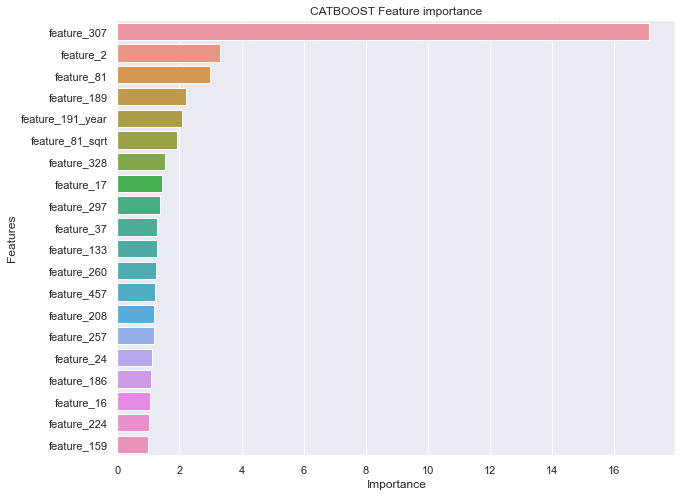

In [58]:
FI=pd.DataFrame({'Features':X.columns,'Importance':CATBOOST.feature_importances_})
FI=FI.sort_values(by='Importance',ascending=False)[:20]
#plot
plt.figure(figsize=(10,8))
sns.barplot(x=FI.Importance,y=FI.Features).set_title('CATBOOST Feature importance')

In [59]:
toDrop=['feature_82','feature_192_year','feature_199_year','feature_200_year','feature_201_year']

LGBM_pred=LGBM.predict_proba(test_e.drop(toDrop,axis=1))
XGB_pred=XGB.predict_proba(test_e.drop(toDrop,axis=1))
CATBOOST_pred=CATBOOST.predict_proba(test_e.drop(toDrop,axis=1))

In [60]:
test_predictions = 0.4 * LGBM_pred[:,1] + 0.3 * CATBOOST_pred[:,1] + 0.3 * XGB_pred[:,1]

In [61]:
sample['target']=test_predictions
sample.head(10)

import datetime
now = datetime.datetime.now()
str_datetime = now.strftime("%y%m%d_%H%M%S")
sample.to_csv(DIR_DATASET + 'submission-' + NAME_PROJECT + '-'+str_datetime+'.csv', index = False)